
# Deep convolutional neural network for lung nodule detection inspired from the YOLO algorithm 

The YOLO algorithm is an extremely fast real-time object detection algorithm. Using ideas from the same, a deep convolutional neural network was trained to detect lung nodules obtained from the LIDC-IDRI dataset that consists of annotated CT scans of 1018 patients. 

### Previous work in the area

Current state of the art systems are 2 stages using 3-d convolutional neural networks for lung nodule detection and obtain an accuracy of 70 to 80 percent. 
Some papers: 

1. http://ieeexplore.ieee.org/document/7727205/
2. https://arxiv.org/pdf/1705.09435.pdf
3. http://cs231n.stanford.edu/reports/2017/pdfs/518.pdf

We aim to detect lung nodules using 2-D features and without multiple sliding window passes through a convolutional neural network. A normal neural network trained for classifying cropped nodules and non-nodule areas, followed by passing the bigger image into the neural network did not work. We believe it is because producing such heat maps, say for a car, is different because unlike a car, a lung nodule looks very similar to other non-nodules and many other areas of the lung. 

# Highlights of the project 

1. The only pre-processing done was standardizing the pixel values using the mean and standard deviation of the CT scan values that were in HOUNSFIELD UNITS(HU). No segmentation was done. 
2. Training was performed on Amazon's cloud service AWS. It took less than 6 hours to train the model to get an accuracy of 49% (Accuracy is described in the last section of this notebook)
3. We have included the detection of both nodules >3 mm and nodules <3 mm which was challenging. 

First, all the required libraries are imported. The image ordering for tensorflow and the keras backend were checked.

In [12]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import glob
import pickle
import numpy as np
import sys, os
import pylab
import time 
import scipy.misc
import matplotlib
import re
# import cv2
from PIL import Image

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Lambda,Input, concatenate, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.utils import np_utils 
from keras import optimizers 
from keras.models import load_model
from keras.models import model_from_json

import keras.backend as K 
K.set_image_dim_ordering('tf')
print('Image ordering is tf check: ',K.image_dim_ordering())
list_of_losses = []

Image ordering is tf check:  tf


The images that were annotated by the radiologists and the corresponding nodule position co-ordinates are imported using the glob function.

In [13]:
nodules = sorted(glob.glob("./YOLO/nodules_whole/*.npy"))
cords = sorted(glob.glob("./YOLO/positions_nodules/*.npy"))
print('Number of images: ',len(nodules))
print('Number of corresponding coordinates: ',len(cords))

#checking if the images and corresponding coords are arranged in order
for filenum in range(0,5000):
    string1 = nodules[filenum]
    string2 = cords[filenum]
    num1 = int(re.search(r'\d+', string1).group())
    num2 = int(re.search(r'\d+', string2).group())
    assert(num1==num2)

Number of images:  5000
Number of corresponding coordinates:  5000


## Creating the training set

For the YOLO algorithm, we create a training set where the 512 by 512 input image is divided into 32 by 32 subimages (16*16 of them). 

These images are passed through the convolutional neural network that would output a 16 by 16 output heat map.

In [14]:
Y = np.zeros((1,16,16))
Y_label_vectors = []
X = []

select_images = np.random.permutation(5000)
select_images[0:10]

array([1101, 4534,  345, 2596, 1782, 2588, 2398, 1927, 2624, 3339])

In [15]:
N_img = 1
# for c in cords[select_images[0:1000]]: 
for s in select_images[0:3000]: 
    
    #Loading the image co-ordinates
    img_cords = np.load(cords[s])
    
    #Loading the image
    img = np.load(nodules[s])

    #coordinates for the particular nodule as annonated by the radiologists 
    x = [xi for xi,yi in img_cords]
    y = [yi for xi,yi in img_cords]

    #Center of the nodule
    avg_x = np.around(np.mean(np.array(x)))
    avg_y = np.around(np.mean(np.array(y)))
    bx = avg_x
    by = avg_y

    #Bounding box dimensions 
    bh = max(y) - min(y)
    bw = max(x) - min(x)

    #Starting pixel values for 8x8 window sliding through the 512 by 512 image
    nx = 0 
    ny = 0 

    #Moving horizontally through the original image
    for yaxis in range(0,16):

        #Starting sliding window from left side of the image 
        nx = 0 

        for xaxis in range(0,16): 

            #16 by 16 sub-image 
            window = img[ny:ny+32, nx:nx+32]

            #window starting and ending pixel coordinates 
            startx = nx
            starty = ny 
            endx = nx+31
            endy = ny+31

            #Initializing the box encodings to 0 
            bx_encoded = 0 
            by_encoded = 0
            bh_encoded = 0 
            nw_encoded = 0 

            #Checking if the radiologist-annotated nodule is in the particular sub-image and recording the corresponding output pixel to be 1
            if avg_x >= startx and avg_x <= endx and avg_y >= starty and avg_y <= endy: 

                #Encoding the bounding box parameters as a fraction of the 8x8 sub-image size
                bh_encoded = bh/512
                bw_encoded = bw/512
#                 bx_encoded = (bx - nx)/16
#                 by_encoded = (by - ny)/16
                bx_encoded = bx/512
                by_encoded = by/512

                #Setting output image pixel values 
                Y[0,yaxis,xaxis] = 1
#                 Y[1,yaxis,xaxis] = bx_encoded
#                 Y[2,yaxis,xaxis] = by_encoded
#                 Y[3,yaxis,xaxis] = bh_encoded
#                 Y[4,yaxis,xaxis] = bw_encoded
                
#                 Y[yaxis,xaxis,0] = 1
#                 Y[yaxis,xaxis,1] = bx_encoded
#                 Y[yaxis,xaxis,2] = by_encoded
#                 Y[yaxis,xaxis,3] = bh_encoded
#                 Y[yaxis,xaxis,4] = bw_encoded


            else: 
                Y[0,yaxis,xaxis] = 0
#                 Y[1,yaxis,xaxis] = 0
#                 Y[2,yaxis,xaxis] = 0
#                 Y[3,yaxis,xaxis] = 0
#                 Y[4,yaxis,xaxis] = 0
                
#                 Y[yaxis,xaxis,0] = 0
#                 Y[yaxis,xaxis,1] = 0
#                 Y[yaxis,xaxis,2] = 0
#                 Y[yaxis,xaxis,3] = 0
#                 Y[yaxis,xaxis,4] = 0

            #Moving horizontally along the 512 by 512 image
            nx = nx + 32

        #Moving Vertically along the 512 by 512 image 
        ny = ny + 32

    #Adding Y to the label vector 
    Y_label_vectors.append(np.transpose(Y,axes = [1,2,0]))

    #Adding 512 by 512 image to the X vector 
    X.append(img.reshape(512,512,1))

    #Re-initializing Y for the next original image 
    Y = np.zeros((1,16,16))
    
    #Keeping track of number of images
    if N_img%100 == 0 : 
        print('Collected '+str(N_img) +' Images and labels')
        
    N_img+=1

Collected 100 Images and labels
Collected 200 Images and labels
Collected 300 Images and labels
Collected 400 Images and labels
Collected 500 Images and labels
Collected 600 Images and labels
Collected 700 Images and labels
Collected 800 Images and labels
Collected 900 Images and labels
Collected 1000 Images and labels
Collected 1100 Images and labels
Collected 1200 Images and labels
Collected 1300 Images and labels
Collected 1400 Images and labels
Collected 1500 Images and labels
Collected 1600 Images and labels
Collected 1700 Images and labels
Collected 1800 Images and labels
Collected 1900 Images and labels
Collected 2000 Images and labels
Collected 2100 Images and labels
Collected 2200 Images and labels
Collected 2300 Images and labels
Collected 2400 Images and labels
Collected 2500 Images and labels
Collected 2600 Images and labels
Collected 2700 Images and labels
Collected 2800 Images and labels
Collected 2900 Images and labels
Collected 3000 Images and labels


Visualizing some of the data and the output label vectors created.

Shape of X:  (3000, 512, 512, 1)
Shape of Output Y:  (3000, 16, 16, 1)


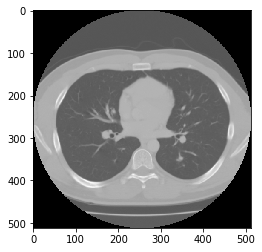

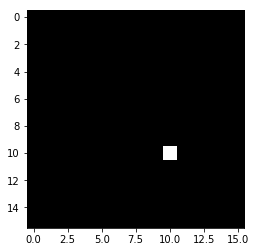

In [16]:
X = np.array(X)
print('Shape of X: ',X.shape)
print('Shape of Output Y: ',np.array(Y_label_vectors).shape)

chp = 5
plt.imshow(X[chp].reshape(512,512),cmap = 'gray')
plt.show()
plt.imshow(np.array(Y_label_vectors)[chp,:,:,0].reshape(16,16),cmap = 'gray')
plt.show()

# np.load(cords[3000:4000][chp])
# np.array(Y_label_vectors).shape

We split the data into testing and training sets and visualize some of the training inputs and outputs. Repeated visualizations are done throughout to keep track of all the processes more effectively and make sense of the data. 

2100 train samples
900 test samples


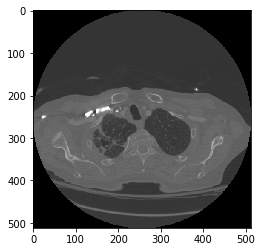

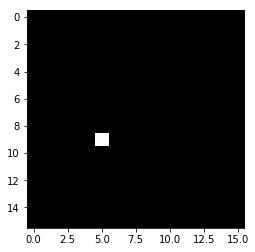

Position of the nodule in the transformed space:  (array([9]), array([5]))
Position of the nodule as annotated by the radiologists:  [array([288]), array([160])]


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, np.array(Y_label_vectors), test_size=0.30)


print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (512,512,1)

ch =0

plt.imshow(X_train[ch,:,:,0],cmap = 'gray')
plt.show()

plt.imshow(np.array(Y_train)[ch,:,:,0],cmap = 'gray')
plt.show()

orig = []
for cor in np.where(np.array(Y_train)[ch,:,:,0]==1):
    orig.append(cor*32)
print('Position of the nodule in the transformed space: ',np.where(np.array(Y_train)[ch,:,:,0]==1))
print('Position of the nodule as annotated by the radiologists: ',orig)

# Convolutional Neural Network For Lung Nodule Detection

We designed a 23 layer convolution neural network that detects nodules with just one pass through the model instead of a sliding window approach that is very computationally expensive. 

## Clearing keras session and specifying input dimensions

In [18]:
import keras.backend as K
K.clear_session()
input_shape = (512,512,1)

## Creating the model

A deep convolutional neural network was designed inspired by the u-net and resnet models. 

In [19]:
model = Sequential([
    Conv2D(32, (3, 3),strides = (1,1), input_shape=input_shape, padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(32, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(32, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,   
    
    
    Conv2D(64, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(64, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(64, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)  ,
    
    
    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(128, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,

    
    
    
    Conv2D(256, (3, 3),strides = (1,1),padding='same', activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)  ,
    
    
    
    Conv2D(512, (3, 3),strides = (1,1),padding='same', activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(512, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(512, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)  ,


    
    
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    
    Conv2D(64, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    
    Conv2D(32, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),

    
    Conv2D(16, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(8, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(1, (3, 3),strides = (1,1),padding='same',activation='sigmoid',name = 'output'),
    
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
__________

## Custom loss function

The logistic loss was used as the objective function. 

In [20]:
def loss_myconv_entire(y_true,y_pred):
    
    y_true_flat_layer0 = K.flatten(y_true[:,:,:,0])
    y_pred_flat_layer0 = K.flatten(y_pred[:,:,:,0])
    
    
    #Logistic loss for the probabilities 
    logistic_loss = K.sum(-y_true_flat_layer0*(K.log(y_pred_flat_layer0)) - (1-y_true_flat_layer0)*(K.log(1-y_pred_flat_layer0)))
    return logistic_loss

## Callback function

In [21]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc =[]
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
    
    
# Create an instance of the history callback
history_cb = LossHistory()

## Compiling and fitting the model

A batch size of 1 was seen to give the best results. 

In [ ]:
#Complilation and fitting
opt= optimizers.Adam(lr = 0.0001)
batch_size = 1
model.compile(loss=loss_myconv_entire, optimizer=opt)
print('Compiled')

model.fit(np.array(X_train), np.array(Y_train), batch_size=batch_size, epochs=1, verbose=1, validation_data=(np.array(X_test), np.array(Y_test)), callbacks = [history_cb])
print('Fitted')

## Saving the model and loss history

In [ ]:
json_string = model.to_json()
model.save_weights('model_3_more_layers_weights')

with open('model_3_more_layers_json.pkl', 'wb') as jm:
    pickle.dump(json_string, jm)

with open('loss_history_model3_more_layers.pkl', 'wb') as lo:
    pickle.dump(history_cb.loss, lo)

In [24]:
# model reconstruction from JSON:
json_string = pickle.load( open( "model_2_json.pkl", "rb" ) )
model_pret = model_from_json(json_string)
model_pret.load_weights('model_2_weights')

loss = pickle.load(open('loss_history_model2.pkl','rb'))

## Plotting the loss history 

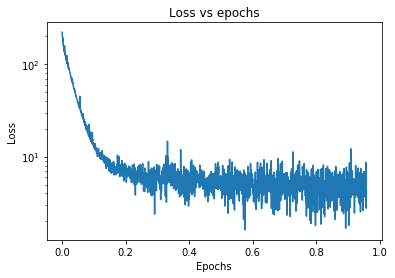

In [25]:
ntr = X_train.shape[0]
epochs = [i*(batch_size/ntr) for i in range(1,len(loss)+1)]
plt.semilogy(epochs,loss)
# plt.semilogy(losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs epochs')
plt.show()

# Analyzing results
### Plotting true and predicted inputs and outputs (Heat Map)

A few results were plotted for different categories where: 

1. The nodule falls in top 1 of the detected nodules
2. The nodule falls in the top 5 of the detected nodules
3. The nodule falls in the top 10 of the detected nodules
4. The nodule doesn't fall in either of the above-mentioned categories

# TOP 1

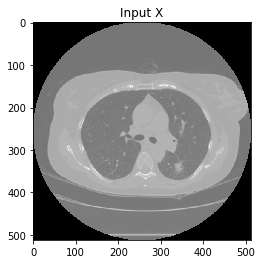

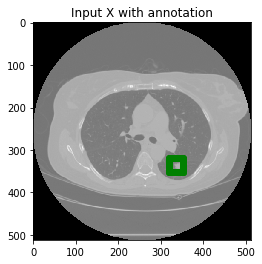

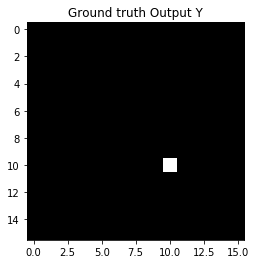

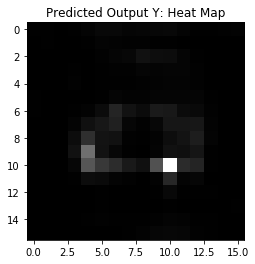

ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION:  (array([0]), array([10]), array([10]))

PREDICTED TOP 1:  (array([10]), array([10]))


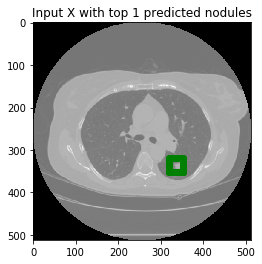

In [46]:
#choosing a random image
choice = 10

#predicting for the image with the trained model
yout = model_pret.predict(X_test[choice:choice+1])

#Plotting input image
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X')
plt.show()

#Plotting input image with annotated nodule
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X with annotation')

#bounding box for annotation 
annot = np.where(Y_test[choice:choice+1,:,:,0]==1)
startx = annot[2][0]*32
endx = startx + 32
starty = annot[1][0]*32
endy = starty + 32

lines_x = []
lines_y = []

toph_x = [xx for xx in range(startx,endx+1)]
toph_y = [starty for new in toph_x]
lines_x.append(toph_x)
lines_y.append(toph_y)

bottomh_x = [xx for xx in range(startx,endx+1)]
bottomh_y = [endy for new in bottomh_x]
lines_x.append(bottomh_x)
lines_y.append(bottomh_y)

leftv_y = [yy for yy in range(starty,endy+1)]
leftv_x=[startx for new in leftv_y]
lines_x.append(leftv_x)
lines_y.append(leftv_y)

rightv_y = [yy for yy in range(starty,endy+1)]
rightv_x = [endx for new in rightv_y]
lines_x.append(rightv_x)
lines_y.append(rightv_y)

plt.plot(lines_x,lines_y,'go')

plt.show()

#Plotting Ground truth/Actual output
plt.imshow(Y_test[choice:choice+1,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Ground truth Output Y')
plt.show()

#Plotting predicted output
plt.imshow(yout[0,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Predicted Output Y: Heat Map')
plt.show()




#Actual max value in the ground truth labels (=1 since a cell containing center of nodule was assigned 1)
print('ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION: ',np.where(Y_test[choice:choice+1,:,:,0]==1))

#Plotting the highest few maximum values in the predicted output

top5 = []
for last in range(1,2):
    print('\nPREDICTED TOP '+str(last) +': ',np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    top5.append(np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    
#Plotting input image with top 5 predicted boundaries
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
for y,x in top5:

    lines_x = []
    lines_y = []
    startx = x[0]*32
    endx = startx + 32
    starty = y[0]*32
    endy = starty + 32
#     X_test[choice:choice+1,:,:,0].reshape(512,512)= cv2.circle(X_test[choice:choice+1,:,:,0].reshape(512,512),(startx,starty),(endx,endy),(0,255,0),1)
    toph_x = [xx for xx in range(startx,endx+1)]
    toph_y = [starty for new in toph_x]
    lines_x.append(toph_x)
    lines_y.append(toph_y)
    
    bottomh_x = [xx for xx in range(startx,endx+1)]
    bottomh_y = [endy for new in bottomh_x]
    lines_x.append(bottomh_x)
    lines_y.append(bottomh_y)
    
    leftv_y = [yy for yy in range(starty,endy+1)]
    leftv_x=[startx for new in leftv_y]
    lines_x.append(leftv_x)
    lines_y.append(leftv_y)
    
    rightv_y = [yy for yy in range(starty,endy+1)]
    rightv_x = [endx for new in rightv_y]
    lines_x.append(rightv_x)
    lines_y.append(rightv_y)
    
    #Plotting bounding box
    plt.plot(lines_x,lines_y,'go')
    
    
plt.title('Input X with top 1 predicted nodules')
plt.show()

# TOP 5

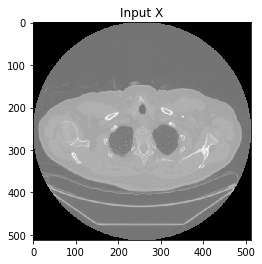

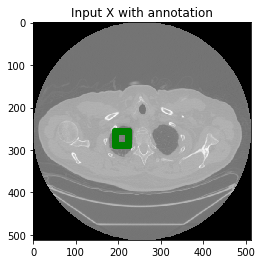

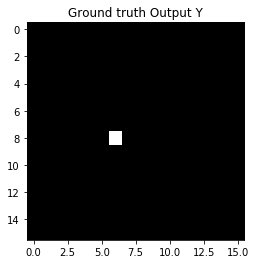

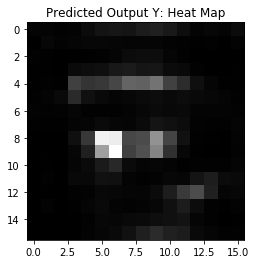

ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION:  (array([0]), array([8]), array([6]))

PREDICTED TOP 1:  (array([9]), array([6]))

PREDICTED TOP 2:  (array([8]), array([5]))

PREDICTED TOP 3:  (array([8]), array([6]))

PREDICTED TOP 4:  (array([9]), array([5]))

PREDICTED TOP 5:  (array([8]), array([9]))


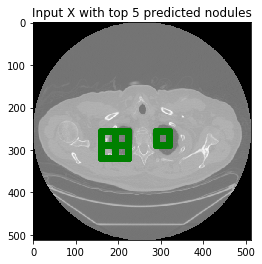

In [32]:
#choosing a random image
choice = 65

#predicting for the image with the trained model
yout = model_pret.predict(X_test[choice:choice+1])

#Plotting input image
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X')
plt.show()

#Plotting input image with annotated nodule
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X with annotation')

#bounding box for annotation 
annot = np.where(Y_test[choice:choice+1,:,:,0]==1)
startx = annot[2][0]*32
endx = startx + 32
starty = annot[1][0]*32
endy = starty + 32

lines_x = []
lines_y = []

toph_x = [xx for xx in range(startx,endx+1)]
toph_y = [starty for new in toph_x]
lines_x.append(toph_x)
lines_y.append(toph_y)

bottomh_x = [xx for xx in range(startx,endx+1)]
bottomh_y = [endy for new in bottomh_x]
lines_x.append(bottomh_x)
lines_y.append(bottomh_y)

leftv_y = [yy for yy in range(starty,endy+1)]
leftv_x=[startx for new in leftv_y]
lines_x.append(leftv_x)
lines_y.append(leftv_y)

rightv_y = [yy for yy in range(starty,endy+1)]
rightv_x = [endx for new in rightv_y]
lines_x.append(rightv_x)
lines_y.append(rightv_y)

plt.plot(lines_x,lines_y,'go')

plt.show()

#Plotting Ground truth/Actual output
plt.imshow(Y_test[choice:choice+1,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Ground truth Output Y')
plt.show()

#Plotting predicted output
plt.imshow(yout[0,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Predicted Output Y: Heat Map')
plt.show()




#Actual max value in the ground truth labels (=1 since a cell containing center of nodule was assigned 1)
print('ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION: ',np.where(Y_test[choice:choice+1,:,:,0]==1))

#Plotting the highest few maximum values in the predicted output

top5 = []
for last in range(1,6):
    print('\nPREDICTED TOP '+str(last) +': ',np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    top5.append(np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    
#Plotting input image with top 5 predicted boundaries
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
for y,x in top5:

    lines_x = []
    lines_y = []
    startx = x[0]*32
    endx = startx + 32
    starty = y[0]*32
    endy = starty + 32
#     X_test[choice:choice+1,:,:,0].reshape(512,512)= cv2.circle(X_test[choice:choice+1,:,:,0].reshape(512,512),(startx,starty),(endx,endy),(0,255,0),1)
    toph_x = [xx for xx in range(startx,endx+1)]
    toph_y = [starty for new in toph_x]
    lines_x.append(toph_x)
    lines_y.append(toph_y)
    
    bottomh_x = [xx for xx in range(startx,endx+1)]
    bottomh_y = [endy for new in bottomh_x]
    lines_x.append(bottomh_x)
    lines_y.append(bottomh_y)
    
    leftv_y = [yy for yy in range(starty,endy+1)]
    leftv_x=[startx for new in leftv_y]
    lines_x.append(leftv_x)
    lines_y.append(leftv_y)
    
    rightv_y = [yy for yy in range(starty,endy+1)]
    rightv_x = [endx for new in rightv_y]
    lines_x.append(rightv_x)
    lines_y.append(rightv_y)
    
    #Plotting bounding box
    plt.plot(lines_x,lines_y,'go')
    
    
plt.title('Input X with top 5 predicted nodules')
plt.show()

# TOP 10

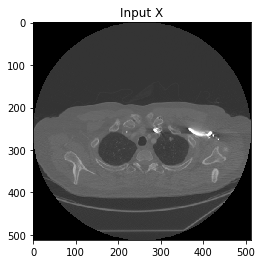

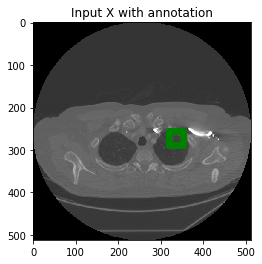

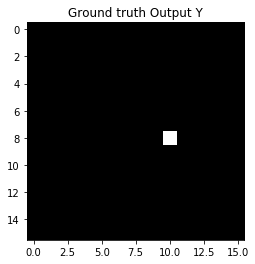

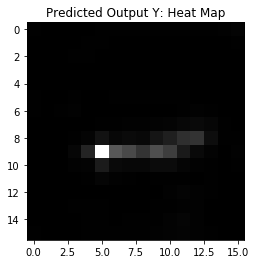

ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION:  (array([0]), array([8]), array([10]))

PREDICTED TOP 1:  (array([9]), array([5]))

PREDICTED TOP 2:  (array([9]), array([6]))

PREDICTED TOP 3:  (array([9]), array([9]))

PREDICTED TOP 4:  (array([9]), array([7]))

PREDICTED TOP 5:  (array([9]), array([10]))

PREDICTED TOP 6:  (array([9]), array([8]))

PREDICTED TOP 7:  (array([8]), array([12]))

PREDICTED TOP 8:  (array([8]), array([11]))

PREDICTED TOP 9:  (array([9]), array([4]))

PREDICTED TOP 10:  (array([8]), array([10]))


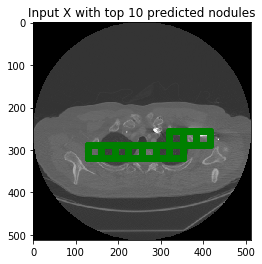

In [34]:
#choosing a random image
choice = 560

#predicting for the image with the trained model
yout = model_pret.predict(X_test[choice:choice+1])

#Plotting input image
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X')
plt.show()

#Plotting input image with annotated nodule
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X with annotation')

#bounding box for annotation 
annot = np.where(Y_test[choice:choice+1,:,:,0]==1)
startx = annot[2][0]*32
endx = startx + 32
starty = annot[1][0]*32
endy = starty + 32

lines_x = []
lines_y = []

toph_x = [xx for xx in range(startx,endx+1)]
toph_y = [starty for new in toph_x]
lines_x.append(toph_x)
lines_y.append(toph_y)

bottomh_x = [xx for xx in range(startx,endx+1)]
bottomh_y = [endy for new in bottomh_x]
lines_x.append(bottomh_x)
lines_y.append(bottomh_y)

leftv_y = [yy for yy in range(starty,endy+1)]
leftv_x=[startx for new in leftv_y]
lines_x.append(leftv_x)
lines_y.append(leftv_y)

rightv_y = [yy for yy in range(starty,endy+1)]
rightv_x = [endx for new in rightv_y]
lines_x.append(rightv_x)
lines_y.append(rightv_y)

plt.plot(lines_x,lines_y,'go')

plt.show()

#Plotting Ground truth/Actual output
plt.imshow(Y_test[choice:choice+1,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Ground truth Output Y')
plt.show()

#Plotting predicted output
plt.imshow(yout[0,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Predicted Output Y: Heat Map')
plt.show()




#Actual max value in the ground truth labels (=1 since a cell containing center of nodule was assigned 1)
print('ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION: ',np.where(Y_test[choice:choice+1,:,:,0]==1))

#Plotting the highest few maximum values in the predicted output

top5 = []
for last in range(1,11):
    print('\nPREDICTED TOP '+str(last) +': ',np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    top5.append(np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    
#Plotting input image with top 5 predicted boundaries
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
for y,x in top5:

    lines_x = []
    lines_y = []
    startx = x[0]*32
    endx = startx + 32
    starty = y[0]*32
    endy = starty + 32
#     X_test[choice:choice+1,:,:,0].reshape(512,512)= cv2.circle(X_test[choice:choice+1,:,:,0].reshape(512,512),(startx,starty),(endx,endy),(0,255,0),1)
    toph_x = [xx for xx in range(startx,endx+1)]
    toph_y = [starty for new in toph_x]
    lines_x.append(toph_x)
    lines_y.append(toph_y)
    
    bottomh_x = [xx for xx in range(startx,endx+1)]
    bottomh_y = [endy for new in bottomh_x]
    lines_x.append(bottomh_x)
    lines_y.append(bottomh_y)
    
    leftv_y = [yy for yy in range(starty,endy+1)]
    leftv_x=[startx for new in leftv_y]
    lines_x.append(leftv_x)
    lines_y.append(leftv_y)
    
    rightv_y = [yy for yy in range(starty,endy+1)]
    rightv_x = [endx for new in rightv_y]
    lines_x.append(rightv_x)
    lines_y.append(rightv_y)
    
    #Plotting bounding box
    plt.plot(lines_x,lines_y,'go')
    
    
plt.title('Input X with top 10 predicted nodules')
plt.show()

# UNDETECTED NODULES

We define the undetected nodules as the nodules that were undetected in the top 10.

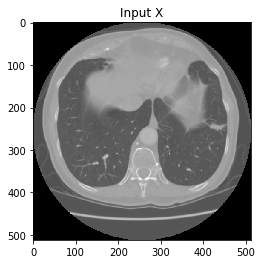

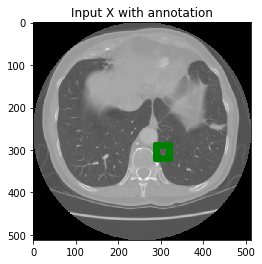

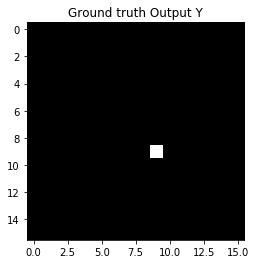

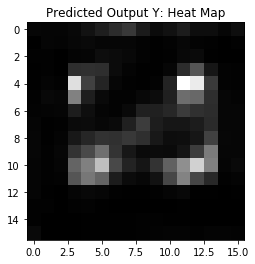

ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION:  (array([0]), array([9]), array([9]))

PREDICTED TOP 1:  (array([4]), array([11]))

PREDICTED TOP 2:  (array([4]), array([12]))

PREDICTED TOP 3:  (array([4]), array([3]))

PREDICTED TOP 4:  (array([10]), array([12]))

PREDICTED TOP 5:  (array([10]), array([5]))

PREDICTED TOP 6:  (array([10]), array([11]))

PREDICTED TOP 7:  (array([11]), array([11]))

PREDICTED TOP 8:  (array([5]), array([3]))

PREDICTED TOP 9:  (array([10]), array([13]))

PREDICTED TOP 10:  (array([10]), array([4]))


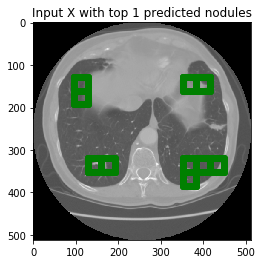

In [36]:
#choosing a random image
choice = 0

#predicting for the image with the trained model
yout = model_pret.predict(X_test[choice:choice+1])

#Plotting input image
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X')
plt.show()

#Plotting input image with annotated nodule
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
plt.title('Input X with annotation')

#bounding box for annotation 
annot = np.where(Y_test[choice:choice+1,:,:,0]==1)
startx = annot[2][0]*32
endx = startx + 32
starty = annot[1][0]*32
endy = starty + 32

lines_x = []
lines_y = []

toph_x = [xx for xx in range(startx,endx+1)]
toph_y = [starty for new in toph_x]
lines_x.append(toph_x)
lines_y.append(toph_y)

bottomh_x = [xx for xx in range(startx,endx+1)]
bottomh_y = [endy for new in bottomh_x]
lines_x.append(bottomh_x)
lines_y.append(bottomh_y)

leftv_y = [yy for yy in range(starty,endy+1)]
leftv_x=[startx for new in leftv_y]
lines_x.append(leftv_x)
lines_y.append(leftv_y)

rightv_y = [yy for yy in range(starty,endy+1)]
rightv_x = [endx for new in rightv_y]
lines_x.append(rightv_x)
lines_y.append(rightv_y)

plt.plot(lines_x,lines_y,'go')

plt.show()

#Plotting Ground truth/Actual output
plt.imshow(Y_test[choice:choice+1,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Ground truth Output Y')
plt.show()

#Plotting predicted output
plt.imshow(yout[0,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Predicted Output Y: Heat Map')
plt.show()




#Actual max value in the ground truth labels (=1 since a cell containing center of nodule was assigned 1)
print('ACTUAL TRANSFORMED CO-ORDINATES OF NODULE POSITION: ',np.where(Y_test[choice:choice+1,:,:,0]==1))

#Plotting the highest few maximum values in the predicted output

top5 = []
for last in range(1,11):
    print('\nPREDICTED TOP '+str(last) +': ',np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    top5.append(np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    
#Plotting input image with top 5 predicted boundaries
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(512,512),cmap = 'gray')
for y,x in top5:

    lines_x = []
    lines_y = []
    startx = x[0]*32
    endx = startx + 32
    starty = y[0]*32
    endy = starty + 32
#     X_test[choice:choice+1,:,:,0].reshape(512,512)= cv2.circle(X_test[choice:choice+1,:,:,0].reshape(512,512),(startx,starty),(endx,endy),(0,255,0),1)
    toph_x = [xx for xx in range(startx,endx+1)]
    toph_y = [starty for new in toph_x]
    lines_x.append(toph_x)
    lines_y.append(toph_y)
    
    bottomh_x = [xx for xx in range(startx,endx+1)]
    bottomh_y = [endy for new in bottomh_x]
    lines_x.append(bottomh_x)
    lines_y.append(bottomh_y)
    
    leftv_y = [yy for yy in range(starty,endy+1)]
    leftv_x=[startx for new in leftv_y]
    lines_x.append(leftv_x)
    lines_y.append(leftv_y)
    
    rightv_y = [yy for yy in range(starty,endy+1)]
    rightv_x = [endx for new in rightv_y]
    lines_x.append(rightv_x)
    lines_y.append(rightv_y)
    
    #Plotting bounding box
    plt.plot(lines_x,lines_y,'go')
    
    
plt.title('Input X with top 1 predicted nodules')
plt.show()

# Accuracy metric 

We define accuracies for 3 different categories of sub-cells based on the output:
1. Nodule found in top 1 
2. Nodule found in top 5 (not including top 1)
3. Nodule found in top 10 (not including top 5)

The final accuracy is a sum of the above-mentioned 3 categories. 

Note: The accuracy is calculated on 900 test images that the model did not see during training. 

## Top 1 Accuracy: 11.8%

In [ ]:
found = 0 
for test_image in range(0,900): 
    
    yout = model.predict(X_test[test_image:test_image+1])


    #Finding position of max value (1) of ground truth label
    max_value = 1 #the sub-cell containing the nodule was set to 1
    cord_tuple = np.where(Y_test[test_image:test_image+1,:,:,0] == 1)
    y_cord = cord_tuple[1][0]
    x_cord = cord_tuple[2][0]
    
    #For top 1
    cords_max = np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-1])
    y_max = np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-1])[0][0]
    x_max = cords_max[1][0]
     
    if y_cord == y_max and x_cord == x_max: 
        found+=1
    
    #Keeping track of the process 
    if test_image%100==0: 
        print('Tested '+str(test_image)+ ' Images')

print('Accuracy, Number of images found in top 1 =', found/900)

## Top 5 Accuracy: 20 %

In [ ]:

found = 0 
for test_image in range(0,100): 
    yout = model.predict(X_test[test_image:test_image+1])


    #Finding position of max value (1) of ground truth label
    max_value = 1 #the sub-cell containing the nodule was set to 1
    cord_tuple = np.where(Y_test[test_image:test_image+1,:,:,0] == 1)
    y_cord = cord_tuple[1][0]
    x_cord = cord_tuple[2][0]
    
    #For top 5
    top5 = []
    
    for last in range(2,6):
        top5.append(np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    
    for got in top5: 
        cords_max = got
        y_max = cords_max[0][0]
        x_max = cords_max[1][0]

        if y_cord == y_max and x_cord == x_max: 
            found+=1
        
    #Keeping track of the process
    if test_image%100==0: 
        print('Tested '+str(test_image)+ ' Images')
        print('Found: ',found)


print('Accuracy, Percentage of images found in top 2 to top 5 not including top 1 =', found/100)

## Top 10 Accuracy: 17%

In [ ]:
found = 0 
for test_image in range(0,900): 
    yout = model_pret.predict(X_test[test_image:test_image+1])


    #Finding position of max value (1) of ground truth label
    max_value = 1 #the sub-cell containing the nodule was set to 1
    cord_tuple = np.where(Y_test[test_image:test_image+1,:,:,0] == 1)
    y_cord = cord_tuple[1][0]
    x_cord = cord_tuple[2][0]
    
    #For top 10
    top10 = []
    
    for last in range(6,11):
        top10.append(np.where(yout[0,:,:,0]==sorted(yout[0,:,:,0].ravel())[-last]))
    
    for got in top10: 
        cords_max = got
        y_max = cords_max[0][0]
        x_max = cords_max[1][0]

        if y_cord == y_max and x_cord == x_max: 
            found+=1
        
    #Keeping track of the process
    if test_image%100==0: 
        print('Tested '+str(test_image)+ ' Images')
        print('Found: ',found)


print('Accuracy, Percentage of images found in top 6 to top 10 not including top 1 and top 5 =', found/900)

In [38]:
FINAL_ACCURACY = 0.12 + 0.20 + 0.17
print('Final Accuracy: ', FINAL_ACCURACY)

Final Accuracy:  0.49


# Conclusion

1. It is a known fact that machine learning algorithms work better if they are given good data and told what they are looking for. Since no segmentation was done, this algorithm detects the presence of nodules with less number of steps compared to other implementations that involve a lot of preprocessing before the images are fed into a neural network. 
2. The algorithm is also good at detecting tiny nodules less than 3 mm in diameter within the top 10 of the predicted sub-cells. 
3. Only a few of the radiologist annotated nodules were used for training. With more images and more training time, we believe the accuracy could be mproved further. 
4. Using more filters and a deeper neural network can also be experimented with to increase accuracy. 
5. This could be used as a stage 1 screening test for lung cancer detection. 
6. The data for training and testing were generated randomly. Around 2-3 accuracy tests with different training and testing data were performed and the values were around 45-50% each time. We have provided the best results we obtained in this notebook. 